# Digital twin tutorial

## Build a machine learning-assisted simulation models

A small tutorial for explaining the use of machine learning in structural dynamics. 

by Merten Stender, m.stender@tuhh.de


### 1. import external libraries

In [1]:
import numpy as np
import aux_funs as aux  # some small subroutines for generating the data
from matplotlib import pyplot as plt
import pickle
from scipy.integrate import odeint  # for ODE time integration
import time

### 2. define simulation model

we will use a single-mass oscillator to model the dynamics observed in the experiment:

$\ddot{x} + 2 \delta \dot{x} + \omega_{n}^{2} x = 0$

Suppose that a first (and very rough) sysstem identification obtained the following model parameters: $\delta = 0.25$, $\omega_n = 3$. We will implement the dynamical system as first-order ordinary differential equation (ODE) as given below:

$\dot{x}_1 = x_2$ 

$\dot{x}_2 = -2 \delta x_2 - \omega_{n}^{2} x_1$

In [2]:
def simulation_model(x, t):
    
    delta = 0.25
    omega = 3
    
    dxdt = [x[1], 
           - 2 * delta * x[1] - omega**2 * x[0]]
    
    return dxdt

### 3. Load measurement data

we load some locally stored measurement data. Particularly, the data is *small*, such that we have only $n_{samples}=100$ measurements. Each measurement consists of $n_{timesteps}=200$ samples for the $n_{dof}=2$ degrees of freedom (displacement $x(t)$ and the velocity $\dot{x}(t)$). 

The measurement data will be stored in the tensor XM, wich has the dimensions [n_samples, n_timesteps, n_dof]. T is the time vector

In [3]:
file = open('historic_data.p', 'rb')
data = pickle.load(file); file.close()    # close the file

XM = data[0]    # list of np arrays [N x n_timesteps x 2]
T = data[1]     # corresponding time vectors
n_timesteps = len(T)

display the first sample of the measurement data

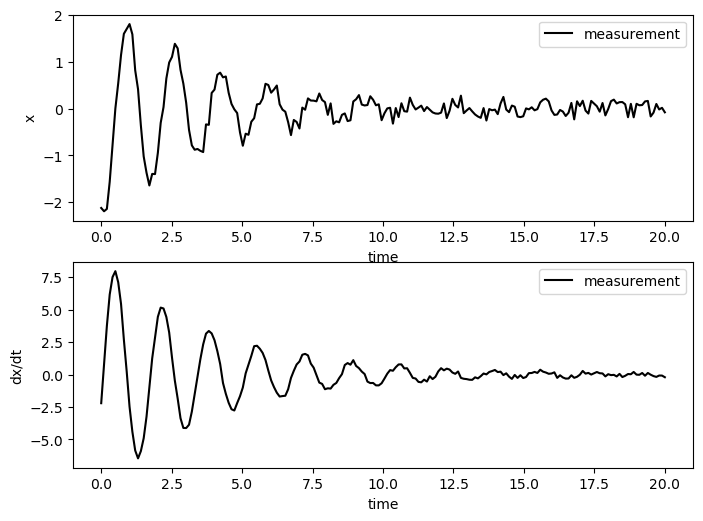

In [4]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(T, XM[0, :, 0], color='black')
plt.xlabel("time"); plt.ylabel("x"); plt.legend(['measurement'])

plt.subplot(2,1,2)
plt.plot(T, XM[0, :, 1], color='black')
plt.xlabel("time"); plt.ylabel("dx/dt"); plt.legend(['measurement'])
plt.show()

### 4. compute simulation predictions for the measurement data

Starting from the initial values provided in the measurement data set, we compute the time signals that our physics-based model, i.e. the single-degree-of-freedom oscillator, would produce.

In [5]:
XS = []  # store all the simulation data in this list

for idx in range(XM.shape[0]):

    print('time integration ' + str(idx) + '/' + str(XM.shape[0]))
    # run a time integration of the physics-based model from the initial
    # conditions provided in the measurement data
    xS = odeint(simulation_model, XM[idx, 0, :], T)
    XS.append(xS)  # store the time integration result

# convert to 3D numpy array to be consistent with XM
XS = np.array(XS)

time integration 0/100
time integration 1/100
time integration 2/100
time integration 3/100
time integration 4/100
time integration 5/100
time integration 6/100
time integration 7/100
time integration 8/100
time integration 9/100
time integration 10/100
time integration 11/100
time integration 12/100
time integration 13/100
time integration 14/100
time integration 15/100
time integration 16/100
time integration 17/100
time integration 18/100
time integration 19/100
time integration 20/100
time integration 21/100
time integration 22/100
time integration 23/100
time integration 24/100
time integration 25/100
time integration 26/100
time integration 27/100
time integration 28/100
time integration 29/100
time integration 30/100
time integration 31/100
time integration 32/100
time integration 33/100
time integration 34/100
time integration 35/100
time integration 36/100
time integration 37/100
time integration 38/100
time integration 39/100
time integration 40/100
time integration 41/100
ti

now compare our model prediction to the measurement data. We can compare the signals themselves, and also compute the Euclidean distance per time step

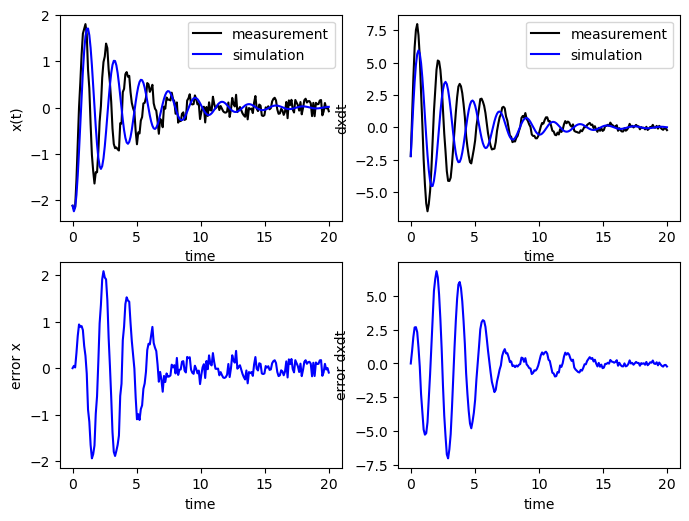

In [6]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplot(2, 2, 1)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.plot(T, XM[0, :, 0], color='black')
plt.plot(T, XS[0, :, 0], color='blue')
plt.legend(['measurement', 'simulation'])

plt.subplot(2, 2, 2)
plt.xlabel("time")
plt.ylabel("dxdt")
plt.plot(T, XM[0, :, 1], color='black')
plt.plot(T, XS[0, :, 1], color='blue')
plt.legend(['measurement', 'simulation'])

plt.subplot(2, 2, 3)
plt.xlabel("time")
plt.ylabel("error x")
plt.plot(T, XM[0, :, 0] - XS[0, :, 0], color='blue')

plt.subplot(2, 2, 4)
plt.xlabel("time")
plt.ylabel("error dxdt")
plt.plot(T, XM[0, :, 1] - XS[0, :, 1], color='blue')
plt.show()

### 6. Design a hybrid digital twin to arrive at better predictions

following the presentation, we build a recurrent neural network model that can compensate for the simulation errors to come up with a better prediction given a set of initial values 

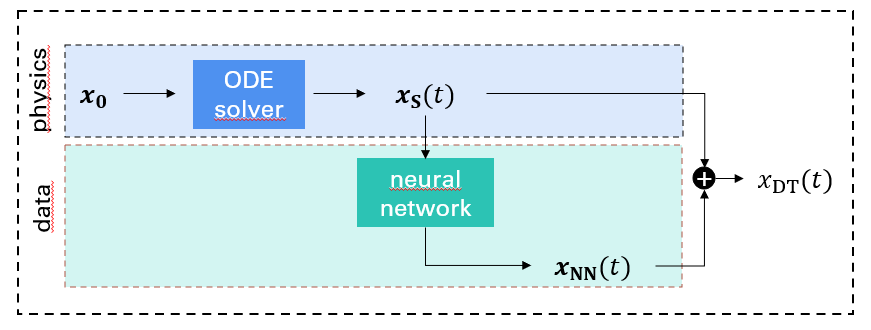


In [7]:
X_in = XS
X_out = XM - XS

# b) reshape into special 3D arrays that are required by Keras LSTM layers
X_in = np.dstack([X_in[:, :, 0], X_in[:, :, 1]])
X_out = np.dstack([X_out[:, :, 0], X_out[:, :, 1]])

# c) split into train-test set (80-20)
split_ratio = 0.8

X_in_train = X_in[:int(len(X_in) * split_ratio), :, :]
X_in_test = X_in[int(len(X_in) * split_ratio):, :, :]

X_out_train = X_out[:int(len(X_out) * split_ratio), :, :]
X_out_test = X_out[int(len(X_out) * split_ratio):, :, :]

XM_train = XM[:int(len(X_in) * split_ratio), :, :]
XM_test = XM[int(len(X_out) * split_ratio):, :, :]

# d) build LSTM network
print('shape of X_in_train is: ' + str(X_in_train.shape) + '; shape of X_out_train is: ' + str(X_out_train.shape))
print('shape of X_in_test is: ' + str(X_in_test.shape) + '; shape of X_out_test is: ' + str(X_out_test.shape))


shape of X_in_train is: (80, 200, 2); shape of X_out_train is: (80, 200, 2)
shape of X_in_test is: (20, 200, 2); shape of X_out_test is: (20, 200, 2)


now construct a recurrent neural network using the Keras API and LSTM and Dense layers. This model is quite simple ('vanilla-type model'), but for this first prototype it is complex enough, having ~42.000 parameters to be optimized during training

In [8]:
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

n_dof = 2
n_outputs = n_timesteps

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_dof),return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(n_dof, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200, 100)          41200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 2)            202       
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________


now train the model on the training set. Observe also the performance on the test set to spot overfitting

In [23]:
epochs, batch_size = 100, 64

start = time.time()  # measure training time
history = model.fit(X_in_train, X_out_train, shuffle=True, epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_in_test, X_out_test), verbose=1)
end = time.time()
print('--> training took ' + str(np.round(end-start, 2)) + ' seconds')

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0524 - accuracy: 0.8196 - val_loss: 0.0313 - val_accuracy: 0.8468
Epoch 2/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0525 - accuracy: 0.8213 - val_loss: 0.0309 - val_accuracy: 0.8468
Epoch 3/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0518 - accuracy: 0.8214 - val_loss: 0.0306 - val_accuracy: 0.8457
Epoch 4/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0497 - accuracy: 0.8256 - val_loss: 0.0319 - val_accuracy: 0.8487
Epoch 5/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0523 - accuracy: 0.8220 - val_loss: 0.0320 - val_accuracy: 0.8415
Epoch 6/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0511 - accuracy: 0.8216 - val_loss: 0.0304 - val_accuracy: 0.8500
Epoch 7/100
80/80 [==============================] - 1s 7ms/step - loss: 0.0509 - accuracy: 0.8259 - val_loss:

80/80 [==============================] - 1s 13ms/step - loss: 0.0422 - accuracy: 0.8378 - val_loss: 0.0242 - val_accuracy: 0.8530
Epoch 59/100
80/80 [==============================] - 1s 9ms/step - loss: 0.0419 - accuracy: 0.8374 - val_loss: 0.0252 - val_accuracy: 0.8478
Epoch 60/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0424 - accuracy: 0.8353 - val_loss: 0.0255 - val_accuracy: 0.8528
Epoch 61/100
80/80 [==============================] - 1s 9ms/step - loss: 0.0431 - accuracy: 0.8401 - val_loss: 0.0244 - val_accuracy: 0.8508
Epoch 62/100
80/80 [==============================] - 1s 9ms/step - loss: 0.0419 - accuracy: 0.8413 - val_loss: 0.0239 - val_accuracy: 0.8530
Epoch 63/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0417 - accuracy: 0.8386 - val_loss: 0.0254 - val_accuracy: 0.8553
Epoch 64/100
80/80 [==============================] - 1s 8ms/step - loss: 0.0423 - accuracy: 0.8352 - val_loss: 0.0250 - val_accuracy: 0.8475
Epoch 65/100
80/80

Evaluate the training process and the final accuracy. Overfitting may occur, which can be observed through increasing training scores and decreasing test scores (diverging loss curves). 

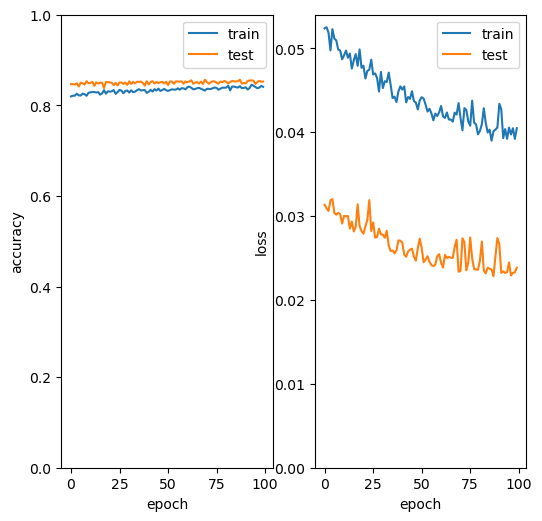

accuracy is = 0.85


In [25]:
# evaluate the model to obtain a final test score
_, accuracy = model.evaluate(X_in_test, X_out_test, batch_size=batch_size, verbose=0)

plt.figure(figsize=(6, 6), dpi=100)
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1])
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(ymin=0)
plt.show()

print('accuracy is = ' + str(np.round(accuracy,2)))

### 8. compile the hybrid digital twin

Now we have all the ingredients ready for compiling the digital twin:
- **physics-based simulation model** (still not being optimal)
- **data-driven machine learning model** (compensating for the model errors)

The behavior prediction for a given initial condition $\mathbf{x}_{0}$ will be a three-step process:
1. run a time integration using the simulation model to obtain $\mathbf{x}_{S}$
2. provide $\mathbf{x}_{S}$ as input to the trained ML model to obtain the correction values $\mathbf{x}_{NN}$
3. obtain the final prediction by adding the previous results: $\mathbf{x}_{DT} = \mathbf{x}_{S} + \mathbf{x}_{NN}$

In [ ]:
def digital_twin(x0, T):

    # 1. get simulation result
    xS = odeint(simulation_model, x0, T)

    # 2. feed simulation into the deep learning model to get correction factors
    xNN = model.predict(np.dstack(np.transpose(xS)))
    xNN = xNN[0, :, :]

    # 3. add simulation and RNN prediction
    xDT = xS + xNN

    return xDT, xS

### 9. make a prediction

1. make a prediction for a data sample from the test set. The ML model has not seen these data before, so it's a good check if our model and the digital twin generalize well.
2. make a prediction for an initial value that lies outside the value range spanned by the training set. Let's see how we perform there

In [ ]:
xM_sample = XM_test[0, :, :]  # 1. test data sample
xDT_sample, xS_sample = digital_twin(xM_sample[0,:], T)

plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.plot(T, xM_sample[:, 0], color='black')
plt.plot(T, xS_sample[:, 0], color='blue', alpha=0.4)
plt.plot(T, xDT_sample[:, 0], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 2)
plt.xlabel("time")
plt.ylabel("dxdt")
plt.plot(T, xM_sample[:, 1], color='black')
plt.plot(T, xS_sample[:, 1], color='blue', alpha=0.4)
plt.plot(T, xDT_sample[:, 1], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 3)
plt.xlabel("time")
plt.ylabel("error x")
plt.plot(T, xM_sample[:, 0] - xS_sample[:, 0], color='blue', alpha=0.4)
plt.plot(T, xM_sample[:, 0] - xDT_sample[:, 0], color='red')
plt.legend(['simulation', 'digital twin'])

plt.subplot(2, 2, 4)
plt.xlabel("time")
plt.ylabel("error dxdt")
plt.plot(T, xM_sample[:, 1] - xS_sample[:, 1], color='blue', alpha=0.4)
plt.plot(T, xM_sample[:, 1] - xDT_sample[:, 1], color='red')
plt.legend(['simulation', 'digital twin'])
plt.show()

now make a prediction for $\mathbf{x}_{0} = [-4, -5]^{\top}$ which is a configuration that lies outside of the training data range. By chance, we have some experimental data for these values, so we can compare the twin to reality

In [ ]:
x0_new = [-4, -5]
xDT_new, xS_new = digital_twin(x0_new, T)     # make a prediction
xM_new = aux.get_measurement_data(x0_new, T)  # load the corresponding data


plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.xlabel("time")
plt.ylabel("x(t)")
plt.plot(T, xM_new[:, 0], color='black')
plt.plot(T, xS_new[:, 0], color='blue', alpha=0.4)
plt.plot(T, xDT_new[:, 0], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 2)
plt.xlabel("time")
plt.ylabel("dxdt")
plt.plot(T, xM_new[:, 1], color='black')
plt.plot(T, xS_new[:, 1], color='blue', alpha=0.4)
plt.plot(T, xDT_new[:, 1], color='red')
plt.legend(['measurement', 'simulation', 'digital twin'])

plt.subplot(2, 2, 3)
plt.xlabel("time")
plt.ylabel("error x")
plt.plot(T, xM_new[:, 0] - xS_new[:, 0], color='blue', alpha=0.4)
plt.plot(T, xM_new[:, 0] - xDT_new[:, 0], color='red')
plt.legend(['simulation', 'digital twin'])

plt.subplot(2, 2, 4)
plt.xlabel("time")
plt.ylabel("error dxdt")
plt.plot(T, xM_new[:, 1] - xS_new[:, 1], color='blue', alpha=0.4)
plt.plot(T, xM_new[:, 1] - xDT_new[:, 1], color='red')
plt.legend(['simulation', 'digital twin'])
plt.show()